In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.6 MB/s eta 0:00:00


In [3]:
# Import libraries
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0, ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:

# Define dataset2 paths
data_dir = "/content/drive/MyDrive/SHSU-Projects/Final_files/Knee_Dataset_2_Augmented/train_augmented"



# Define batch size
batch_size = 20
IMAGE_SIZE = (240, 240)
classes = ['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']


train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,  # Specify your class names
    shuffle=True,
    #color_mode='grayscale',
    batch_size=batch_size,
    image_size=IMAGE_SIZE,
    validation_split=0.2,  # Adjust the validation split as needed
    subset='training',
    seed=1337
)



val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    #color_mode='grayscale',
    batch_size=batch_size,
    image_size=IMAGE_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=1337
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_2_Original/test',
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    #color_mode='grayscale',
    shuffle=True,
    batch_size=batch_size,
    image_size=IMAGE_SIZE,
    #validation_split=0.2,
    #subset='test',
    seed=1337
)


class_index_to_label = {i: label for i, label in enumerate(train_dataset.class_names)}
print('Class index number mapping to class folder names: ',class_index_to_label)


def preprocess_image(image, label):
    image = tfa.image.equalize(image)
    # image = tfa.image.gaussian_filter2d(image, (3, 3), 1.0)
    return image, label


train_dataset = train_dataset.map(preprocess_image).shuffle(buffer_size=200)
val_dataset = val_dataset.map(preprocess_image)


train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 6725 files belonging to 5 classes.
Using 5380 files for training.
Found 6725 files belonging to 5 classes.
Using 1345 files for validation.
Found 89 files belonging to 5 classes.
Class index number mapping to class folder names:  {0: '0Normal', 1: '1Doubtful', 2: '2Mild', 3: '3Moderate', 4: '4Severe'}


In [5]:

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
#base_model = tf.keras.applications.resnet.ResNet101(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
#base_model = tf.keras.applications.convnext.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
#base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

x = base_model.output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(612, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(210, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

for layer in base_model.layers:
    layer.trainable = True

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

24274472/24274472 [==============================] - 2s 0us/step


List of learning rate:  [6.25e-06, 1.25e-05, 2.5e-05, 5e-05, 0.0001, 9.938441702975689e-05, 9.755282581475769e-05, 9.45503262094184e-05, 9.045084971874738e-05, 8.535533905932738e-05, 7.938926261462366e-05, 7.269952498697734e-05, 6.545084971874738e-05, 5.782172325201155e-05, 5e-05, 4.217827674798846e-05, 3.4549150281252636e-05, 2.7300475013022663e-05, 2.061073738537635e-05, 1.4644660940672627e-05]


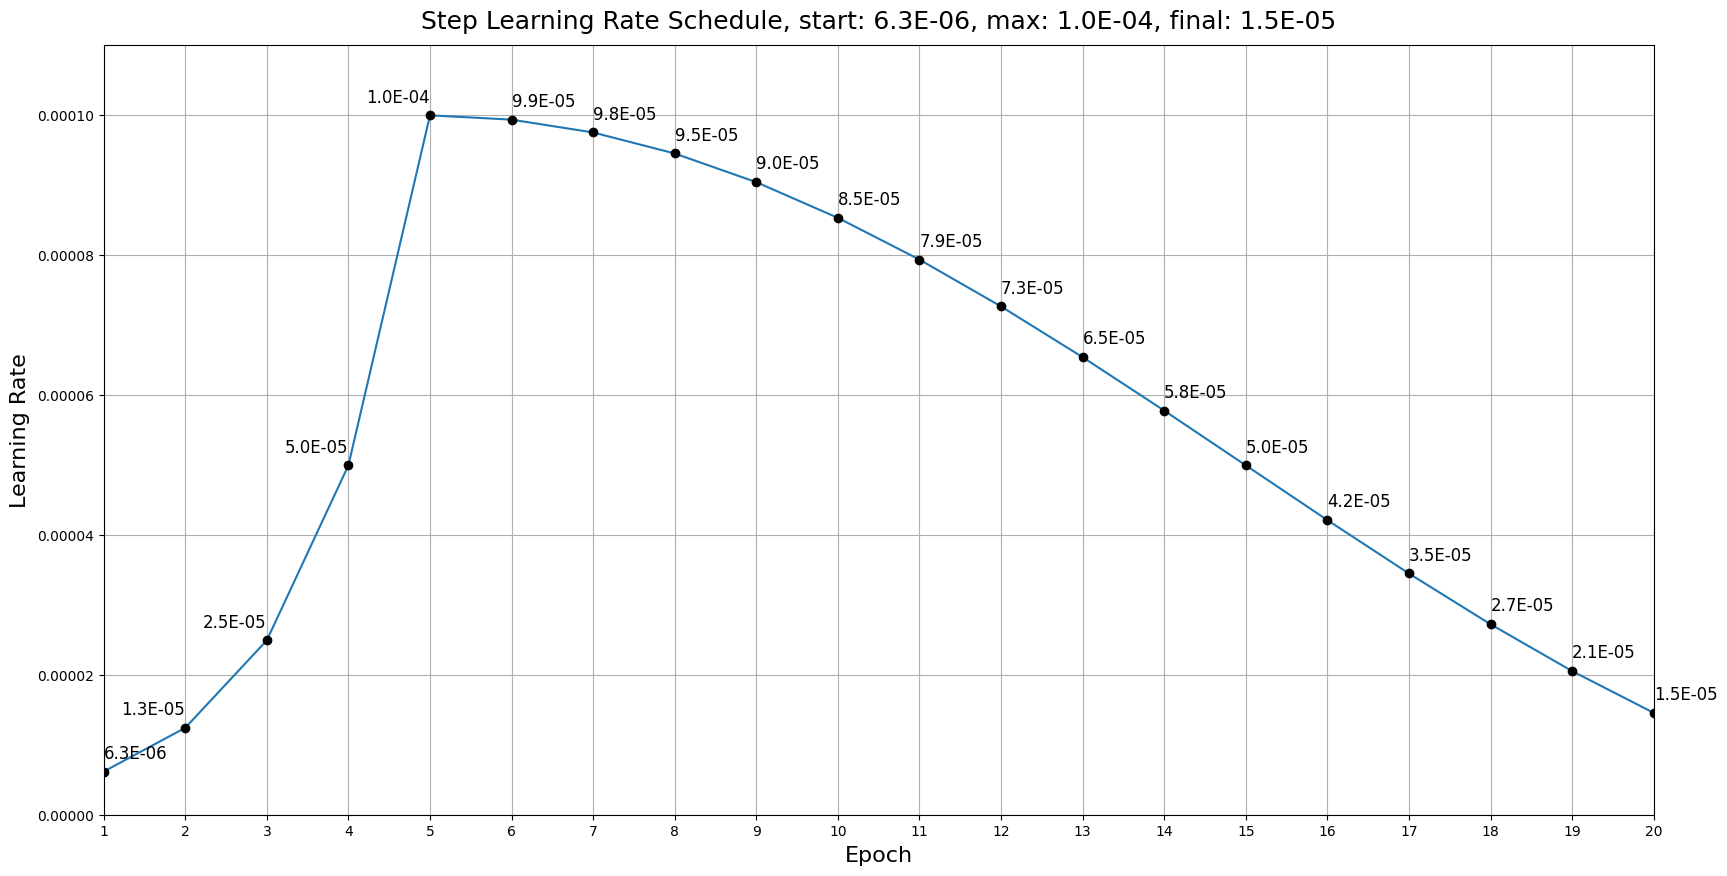

In [6]:
# Import libraries
import math
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

N_EPOCHS = 20
warm_up_ep  = 4
num_cycles  = 0.4
lr_max = 1e-4

def learning_rate_fn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    if current_step < num_warmup_steps:
        # exponiancial warmup
        return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max


def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    plt.ylim([0, max(lr_schedule) * 1.1])

    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()




LR_SCHEDULE = [learning_rate_fn(step, num_warmup_steps=warm_up_ep, lr_max=lr_max, num_cycles=num_cycles, num_training_steps=N_EPOCHS) for step in range(N_EPOCHS)]
print('List of learning rate: ', LR_SCHEDULE)

plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)



In [7]:
#LR_SCHEDULE

In [8]:
#lr_list = [ 0.00001, 0.00006, 0.00003, 0.00002, 0.00002, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001 ]


my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_2_after_augmentation_EfficientNetV2B0_final.h5', save_best_only=True),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),  # Stop training if no improvement after 3 epochs
    #tf.keras.callbacks.LearningRateScheduler(lambda step: lr_list[step], verbose=0),
    tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)
    #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-5, verbose=1)
]



model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
)


history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    validation_data=val_dataset,
    callbacks=[my_callbacks],
)



Epoch 1/20
269/269 [==============================] - ETA: 0s - loss: 23.5520 - accuracy: 0.2093

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


269/269 [==============================] - 406s 496ms/step - loss: 23.5520 - accuracy: 0.2093 - val_loss: 23.2351 - val_accuracy: 0.2610 - lr: 6.2500e-06
Epoch 2/20
269/269 [==============================] - 23s 71ms/step - loss: 22.7693 - accuracy: 0.2405 - val_loss: 22.2216 - val_accuracy: 0.3836 - lr: 1.2500e-05
Epoch 3/20
269/269 [==============================] - 24s 72ms/step - loss: 21.2943 - accuracy: 0.3026 - val_loss: 20.2520 - val_accuracy: 0.4892 - lr: 2.5000e-05
Epoch 4/20
269/269 [==============================] - 24s 74ms/step - loss: 18.4474 - accuracy: 0.4654 - val_loss: 16.5164 - val_accuracy: 0.5948 - lr: 5.0000e-05
Epoch 5/20
269/269 [==============================] - 23s 72ms/step - loss: 13.7715 - accuracy: 0.6489 - val_loss: 11.0514 - val_accuracy: 0.7762 - lr: 1.0000e-04
Epoch 6/20
269/269 [==============================] - 24s 73ms/step - loss: 9.2456 - accuracy: 0.7721 - val_loss: 7.4243 - val_accuracy: 0.8349 - lr: 9.9384e-05
Epoch 7/20
269/269 [=============

In [9]:
#model.load_weights('/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_2_after_augmented_convxNxtBase_model_weights.weight')

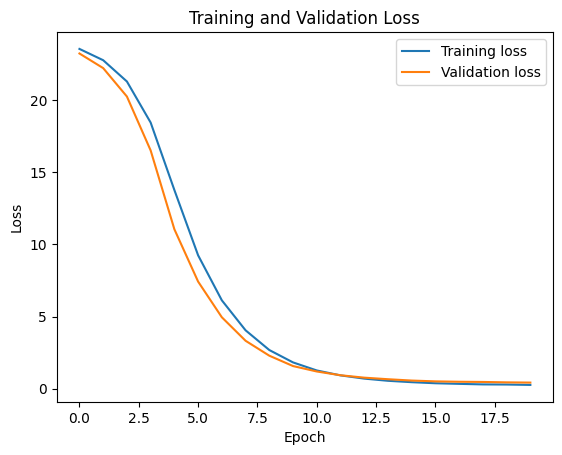

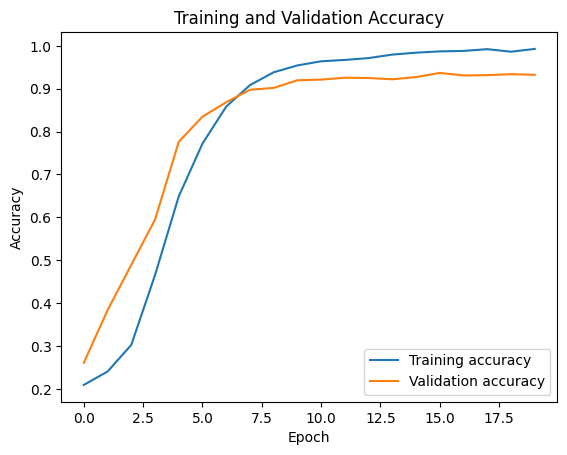

In [10]:
import matplotlib.pyplot as plt

# Plot the training and validation loss curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
test_loss, test_accuracy = model.evaluate(test_dataset)

print('Test accuracy:', test_accuracy)

5/5 [==============================] - 7s 44ms/step - loss: 1.2364 - accuracy: 0.6404
Test accuracy: 0.6404494643211365


### Model Loading

1/1 [==============================] - 0s 27ms/step
Confusion Matrix:


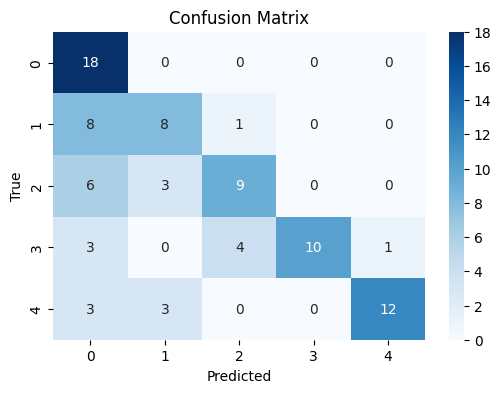


Classification Report:
              precision    recall  f1-score   support

           0       0.47      1.00      0.64        18
           1       0.57      0.47      0.52        17
           2       0.64      0.50      0.56        18
           3       1.00      0.56      0.71        18
           4       0.92      0.67      0.77        18

    accuracy                           0.64        89
   macro avg       0.72      0.64      0.64        89
weighted avg       0.72      0.64      0.64        89



In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np


val_results = model.evaluate(test_dataset)

y_true = []
y_pred = []

for x_val, y_val in test_dataset:
    predictions = model.predict(x_val)
    y_true.extend(np.argmax(y_val, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
#print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))
